#### Session-Stopper

In [ ]:
import time
for i in range(50):
  print('Stop: ', i)
  time.sleep(30*60)

-----

In [1]:
!pip install -q pymap3d


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import numpy as np
from math import atan2, asin
import pandas as pd
from IPython.display import display
from pprint import pprint
from PIL import Image
import time
import datetime
import time
import sys
from pymap3d import geodetic2enu, enu2geodetic
import warnings
warnings.filterwarnings('ignore')

image_size = (1920, 1200)
fx, fy, cx, cy = [718.8560, 718.8560, 607.1928, 185.2157]
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

In [3]:
!unzip -q /content/optical-edge-dev.zip

unzip:  cannot find or open /content/optical-edge-dev.zip, /content/optical-edge-dev.zip.zip or /content/optical-edge-dev.zip.ZIP.


------

In [ ]:
!unzip -q sample-dataset-xs.zip

In [3]:
sys.path.append('/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/optical-edge-dev')
# sys.path.append('/content/optical-edge-dev')
import pose_est
from pose_est import *
import vo
from vo import Stitcher
from vo import FeatureLocalization

In [4]:
sys.path.append('/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/py_files')
import Utils
from Utils import *

In [7]:
import importlib
importlib.reload(vo)
importlib.reload(Utils)

<module 'Utils' from '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/py_files/Utils.py'>

### Google Colab (implementation)

In [6]:
sample_dataset_path = r"/content/sample-dataset-xs"

----

In [5]:
sample_dataset_dir = r"/home/datademon/Desktop/E254/cam"
keyword = 'str'
sample_parent_dir = [nm for nm in os.listdir(sample_dataset_dir) if nm[:3] == keyword]
sample_parent_dir = sorted(sample_parent_dir, key = lambda k: k.split('_')[1])
print(sample_parent_dir)

['strip_E254_1679940374', 'strip_E254_1679940611', 'strip_E254_1679940299', 'strip_E254_1679940455', 'strip_E254_1679940686', 'strip_E254_1679940530']


In [6]:
choice = 0
print('Strip-Selected: ', sample_parent_dir[choice])
sample_dataset_path = os.path.join(sample_dataset_dir, sample_parent_dir[choice])
mid_dir = sample_parent_dir[choice].split('_')[1]
save_parent_dir = f"/home/datademon/Desktop/Alik/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/{mid_dir}"
if not os.path.isdir(save_parent_dir):
  os.mkdir(save_parent_dir)
save_file_name = f'{save_parent_dir}/flight_parameters_estimation_{sample_parent_dir[choice]}.csv'
print('Save-Path: ', save_file_name)

sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]
print('No. of Samples: ', len(sample_dir))


def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)
print(sample_dir[:2])
sample_parent_dir = sorted(sample_parent_dir, key = lambda k: k.split('_')[1])
print(sample_parent_dir)

Strip-Selected:  strip_E254_1679940374
Save-Path:  /home/datademon/Desktop/Alik/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/E254/flight_parameters_estimation_strip_E254_1679940374.csv
No. of Samples:  187
['img_E254_727355912112_1679940374_884835917.tiff', 'img_E254_727689204540_1679940375_217563396.tiff']
['strip_E254_1679940374', 'strip_E254_1679940611', 'strip_E254_1679940299', 'strip_E254_1679940455', 'strip_E254_1679940686', 'strip_E254_1679940530']


##### Arranging frame sequence w.r.t logging parameter (NOT Jetson Time)

In [7]:
sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]

def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)

''' Taking only n=100 samples for stitching '''
num_take = 25
sample_dir = sample_dir[:num_take]

print('No. of Samples: ', len(sample_dir))
print(sample_dir[:2])

No. of Samples:  25
['img_E254_727355912112_1679940374_884835917.tiff', 'img_E254_727689204540_1679940375_217563396.tiff']


In [8]:
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

print(timestamps_list)
print(utc_timestamps_list)

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, sample_dir):
  flight_obj[time] = path
  rev_flight_obj[path] = time

print()
print('Time-Wise Path Storages -')
print()
# pprint(flight_obj)

['1679940374_884835917', '1679940375_217563396', '1679940375_551332050', '1679940375_884573620', '1679940376_217785333', '1679940376_551153818', '1679940376_884386556', '1679940377_217779458', '1679940377_551060421', '1679940377_884270182', '1679940378_217189953', '1679940378_550426564', '1679940378_883840810', '1679940379_217055819', '1679940379_550416720', '1679940379_883607089', '1679940380_216956374', '1679940380_550168183', '1679940380_883502907', '1679940381_216653596', '1679940381_549974112', '1679940381_883283043', '1679940382_216497893', '1679940382_549823913', '1679940382_883127885']
['2023-03-27 23:36:14.884836', '2023-03-27 23:36:15.217563', '2023-03-27 23:36:15.551332', '2023-03-27 23:36:15.884574', '2023-03-27 23:36:16.217785', '2023-03-27 23:36:16.551154', '2023-03-27 23:36:16.884387', '2023-03-27 23:36:17.217779', '2023-03-27 23:36:17.551060', '2023-03-27 23:36:17.884270', '2023-03-27 23:36:18.217190', '2023-03-27 23:36:18.550427', '2023-03-27 23:36:18.883841', '2023-03

Random-ENT:  12
t = 2023-03-27 23:36:18.883841 --> img_E254_731355394545_1679940378_883840810.tiff UTC , t = 2023-03-27 23:36:19.217056 --> img_E254_731688684003_1679940379_217055819.tiff UTC
(1200, 1920, 3) (1200, 1920, 3)


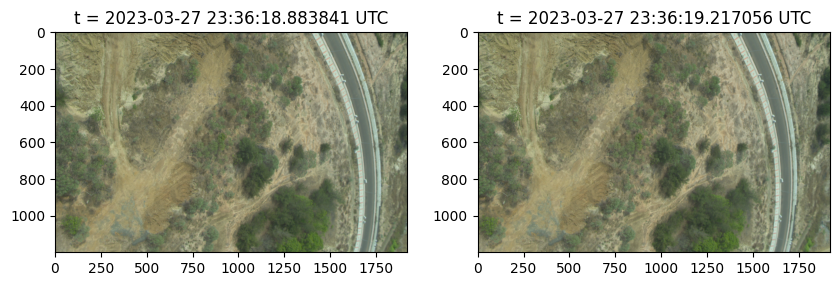

In [9]:
rn_ent = random.randint(0, len(sample_dir) - 2)
print('Random-ENT: ', rn_ent)

# target_size = (256, 256)

print(f't = {rev_flight_obj[sample_dir[rn_ent]]} --> {sample_dir[rn_ent]} UTC , t = {rev_flight_obj[sample_dir[rn_ent + 1]]} --> {sample_dir[rn_ent + 1]} UTC')
sample_first_path, sample_second_path = os.path.join(sample_dataset_path, sample_dir[rn_ent]), os.path.join(sample_dataset_path, sample_dir[rn_ent + 1])
sample_first_frame, sample_second_frame = Image.open(sample_first_path), Image.open(sample_second_path)
sample_first_frame, sample_second_frame = np.asarray(sample_first_frame), np.asarray(sample_second_frame)
# sample_first_frame, sample_second_frame = cv2.resize(sample_first_frame, target_size), cv2.resize(sample_second_frame, target_size)

print(sample_first_frame.shape, sample_second_frame.shape)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

axs[0].imshow(sample_first_frame)
axs[0].set_title(f't = {rev_flight_obj[sample_dir[rn_ent]]} UTC')

axs[1].imshow(sample_second_frame)
axs[1].set_title(f't = {rev_flight_obj[sample_dir[rn_ent + 1]]} UTC')

plt.show()

### Optical-Stitching

In [10]:
image_size = (1920, 1200)
resized_frames = np.array([cv2.resize(cv2.imread(os.path.join(sample_dataset_path, nm)), image_size) for nm in sample_dir])
print(resized_frames.shape)
# resized_frames = np.array([resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0]])
# print(resized_frames.shape)

(25, 1200, 1920, 3)


### Translation-Vector-Error

In [11]:
num_frames = len(resized_frames)

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75

Num-Frames:  25


In [12]:
import time

t_err = []
euler_angle_list = []
translation_list = []
ft = time.time()

for i in tqdm((range(num_frames)), desc="Extracting t-Error Values", unit="frame"):
  
  temp_resized_frames = np.array([resized_frames[i], resized_frames[i]])
  # print(temp_resized_frames.shape)

  for j in range(len(temp_resized_frames)):
    
    if j == 0:
        result_img = temp_resized_frames[j]
        curr_R = np.eye(3)
        curr_t = np.array([0, 0, 0]).astype('float64')

    else:
        Image1 = result_img
        Image2 = temp_resized_frames[j]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        # Calling function for stitching images.

        eae = EAE(Image2, Image1)
        _, t, euler_angle_rad, _ = eae.run(is_store = True)
        euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        R = euler_angles_to_rotation_matrix(euler_angle)
        # result_img = manual_stitch_frames(Image2, Image1)
        
        t_err.append(t)
        ''' For Comparison '''

        # stitcher = Stitcher(Image2, Image1, detector, matcher, threshold)
        # _, R_temp, _ = stitcher.stitch_frames(curr_R, curr_t, fx, cx, cy)

        # # print('R: ', R)
        # # print()
        # # print('R_temp: ', R_temp)
        # print('Diff: ', abs(R - R_temp))
        # print()

        if j == 1:
          
          prev_R = curr_R
          prev_t = curr_t

          curr_R = R
          curr_t = t

        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)


        result_img = manual_stitch_frames(Image2, Image1, prev_R, np.squeeze(prev_t), curr_R, np.squeeze(curr_t))

        prev_R = curr_R
        prev_t = abs(curr_t)
  pass

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

t_err = np.array(t_err)
print(t_err.shape)

Extracting t-Error Values:   0%|          | 0/25 [00:00<?, ?frame/s]

Extracting t-Error Values:   4%|▍         | 1/25 [00:01<00:25,  1.08s/frame]

Extracting t-Error Values:   8%|▊         | 2/25 [00:02<00:23,  1.04s/frame]

Extracting t-Error Values:  12%|█▏        | 3/25 [00:03<00:23,  1.06s/frame]

Extracting t-Error Values:  16%|█▌        | 4/25 [00:04<00:22,  1.05s/frame]

Extracting t-Error Values:  20%|██        | 5/25 [00:05<00:22,  1.11s/frame]


KeyboardInterrupt: 

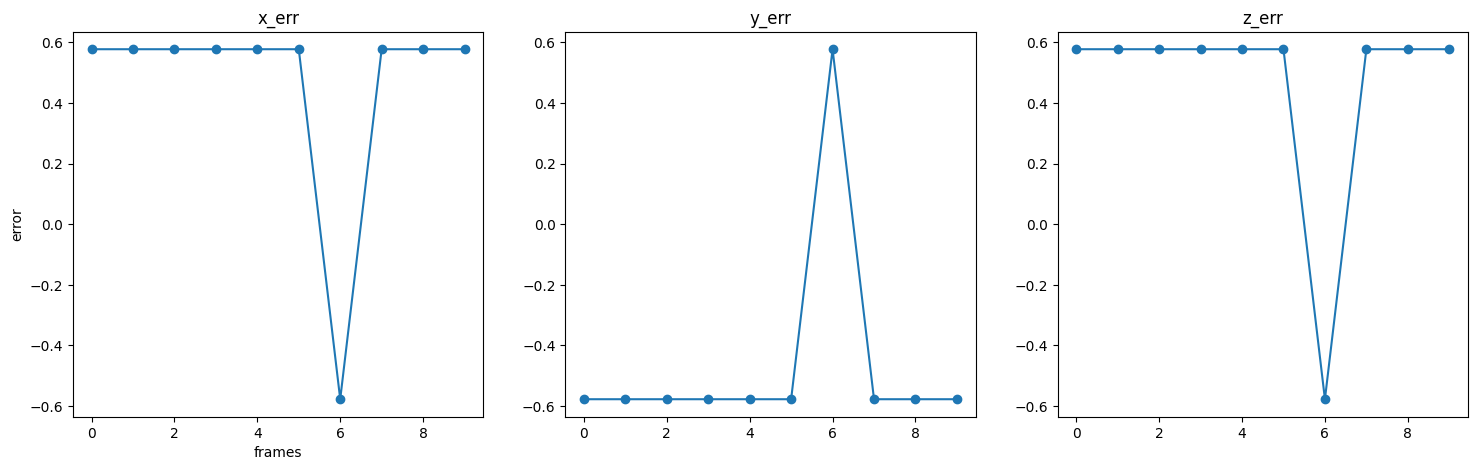

In [18]:
''' SANITY-CHECK '''

# t_err = 10 * np.ones(t_err.shape)
# print(t_err.shape)

t_err = np.squeeze(t_err)
x_err, y_err, z_err = t_err[:, 0], t_err[:, 1], t_err[:, -1]

fig, axs = plt.subplots(1, 3, figsize = (18, 5))

axs[0].plot(x_err, marker = 'o')
axs[0].set_title('x_err')
axs[0].set_xlabel('frames')
axs[0].set_ylabel('error')


axs[1].plot(y_err, marker = 'o')
axs[1].set_title('y_err')

axs[2].plot(z_err, marker = 'o')
axs[2].set_title('z_err')

plt.show()

In [68]:
# resized_frames = np.array([resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0]])
# print(resized_frames.shape)

Num-Frames:  10


Stitching frames:   0%|          | 0/10 [00:00<?, ?frame/s]

Stitching frames:  20%|██        | 2/10 [00:00<00:03,  2.01frame/s]

Stitching frames:  30%|███       | 3/10 [00:02<00:05,  1.38frame/s]

Stitching frames:  40%|████      | 4/10 [00:03<00:05,  1.16frame/s]

Stitching frames:  50%|█████     | 5/10 [00:04<00:04,  1.04frame/s]

Stitching frames:  60%|██████    | 6/10 [00:05<00:04,  1.04s/frame]

Stitching frames:  70%|███████   | 7/10 [00:06<00:03,  1.11s/frame]

Stitching frames:  80%|████████  | 8/10 [00:08<00:02,  1.19s/frame]

Stitching frames:  90%|█████████ | 9/10 [00:09<00:01,  1.25s/frame]

Stitching frames: 100%|██████████| 10/10 [00:10<00:00,  1.09s/frame]


Execution-time (UNIX):  10.891234874725342


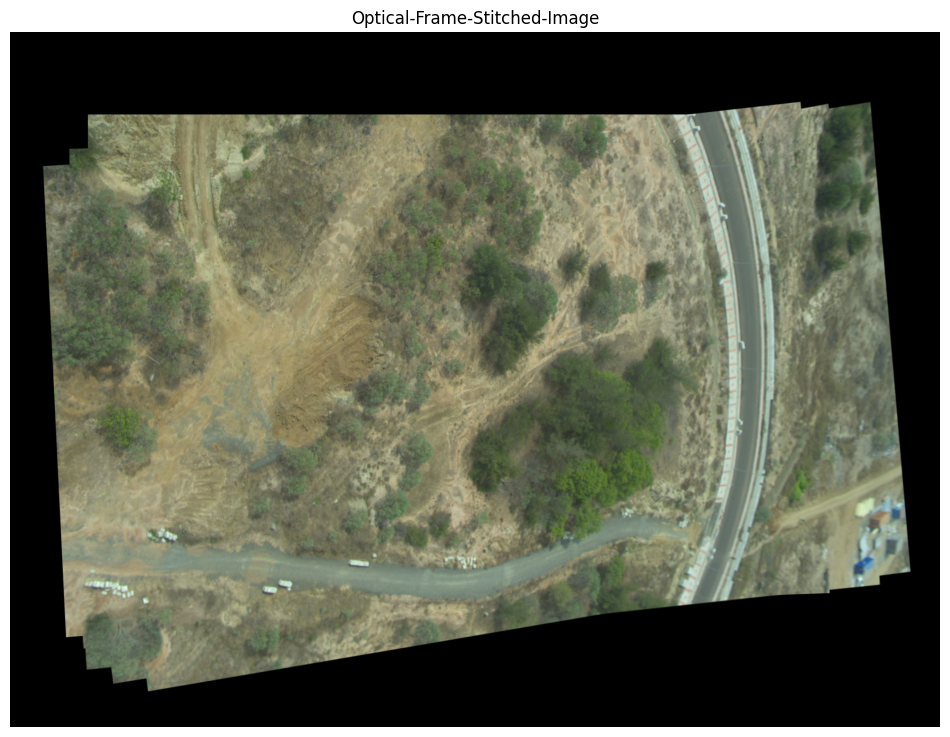

In [22]:
import time

num_frames = len(resized_frames)
# num_frames = 5

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75
trajMap = np.zeros((*image_size, 3), dtype=np.uint8)

euler_angle_list = []
translation_list = []

t_corr = [False, t_err]

ft = time.time()
for i in tqdm((range(num_frames)), desc="Stitching frames", unit="frame"):

    if i == 0:
        result_img = resized_frames[i]
        curr_R = np.eye(3)
        curr_t = np.array([0, 0, 0]).astype('float64')

    else:
        Image1 = result_img
        Image2 = resized_frames[i]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        t_corr[0] = False
        eae = EAE(Image2, Image1)
        _, t, euler_angle_rad, _ = eae.run(t_corr = t_corr, is_store = True)
        euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        R = euler_angles_to_rotation_matrix(euler_angle)
        euler_angle_list.append(euler_angle)

        # Calling function for stitching images.prev_t
        # stitcher = Stitcher(Image2, Image1, detector, matcher, threshold)
        # _, R_temp, _ = stitcher.stitch_frames(curr_R, curr_t, fx, cx, cy)

        if i == 1:
          prev_R = curr_R
          prev_t = curr_t

          curr_R = R
          curr_t = t
          
        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)

        result_img = manual_stitch_frames(Image2, Image1, prev_R, np.squeeze(prev_t), curr_R, np.squeeze(curr_t))

        prev_R = curr_R
        prev_t = abs(curr_t)

    pass

lt = time.time()
        
print('Execution-time (UNIX): ', (lt - ft))

fig, axs = plt.subplots(1, 1, figsize = (12, 12))

result_img = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
# result_img = cv2.resize(result_img, image_size)

axs.imshow(result_img)
axs.set_title('Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

In [83]:
import tifffile

nm = 'abc' + '2' #+ '_corr'
tifffile.imwrite(f'/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/{nm}.tiff', result_img)

['/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc2.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc0.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc1_corr.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc0_corr.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc2_corr.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc1.tiff']
['/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc2.tiff', '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight

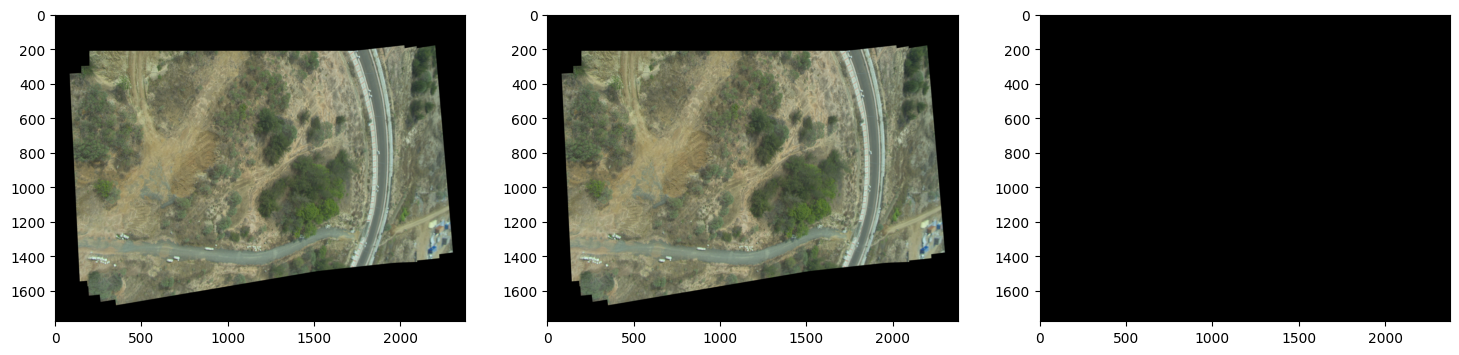

In [87]:
from PIL import Image
from pprint import pprint

parent_dir = r'/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES'

req_path = [os.path.join(parent_dir, path) for path in os.listdir(parent_dir) if path[:3] == 'abc']
pprint(req_path)

print(req_path)

img, img_corr = np.asarray(Image.open(req_path[0])), np.asarray(Image.open(req_path[4]))
img, img_corr = (img / 255).astype('float64'), (img_corr / 255).astype('float64')

print(img.shape, img_corr.shape)

img_corr = cv2.resize(img_corr, (img.shape[1], img.shape[0]))

fig, axs = plt.subplots(1, 3, figsize = (18, 7))

axs[0].imshow(img)
axs[1].imshow(img_corr)
axs[2].imshow(img - img_corr)

plt.show()

# print(img[:10])
# print()
# print(img_corr[:10])

### PLOT

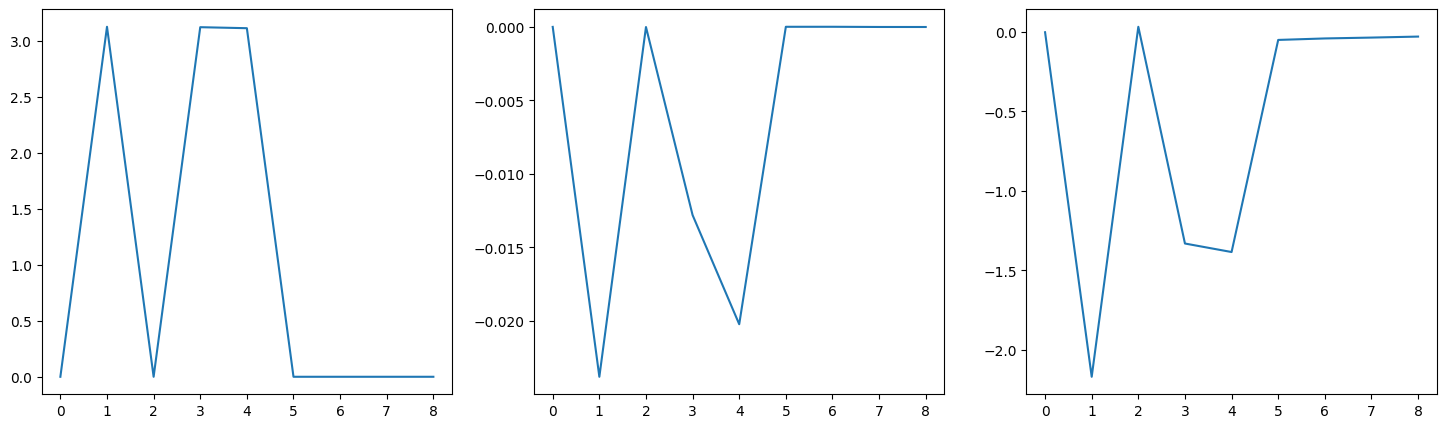

In [24]:
# print(euler_angle_list)
euler_angle_list = np.array(euler_angle_list)
# print(euler_angle_list.shape)
roll, pitch, yaw = euler_angle_list[:, 0], euler_angle_list[:, 1], euler_angle_list[:, 2]

fig, axs = plt.subplots(1, 3, figsize = (18, 5))

axs[0].plot(roll)
axs[1].plot(pitch)
axs[2].plot(yaw)

plt.show()

# translation_list = np.squeeze(np.array(translation_list))
# # print(translation_list.shape)
# x, y, z = translation_list[:, 0], translation_list[:, 1], translation_list[:, -1]
# # print(x, y, z)
# fig, axs = plt.subplots(1, 3, figsize = (18, 5))

# axs[0].plot(x)
# axs[1].plot(y)
# axs[2].plot(z)

# plt.show()


In [ ]:
import tifffile

tifffile.imwrite(f'/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/stitched_img_{sample_parent_dir[choice]}_for_{num_frames}_frames.tiff', result_img)

#### Bundle Adjustment (Global Optimization)
2-view stereo view [CASE]

In [13]:
def plot_key_points(image, kp):

  output_image = image.copy()

  for _kp in kp:
    x, y = _kp.pt
    size = _kp.size
    color = (0, 255, 0)
    thickness = 2

    cv2.circle(output_image, (int(x), int(y)), int(max(1, size)), color, thickness)

  return output_image

In [14]:
def plot_feature_matches(image1, image2, keypoints1, keypoints2, good_matches):

  height1, width1 = image1.shape[:2]
  height2, width2 = image2.shape[:2]

  combined_img = cv2.hconcat([image1, image2])

  for match in good_matches:
    m_idx = match[0].queryIdx
    n_idx = match[0].trainIdx

    (x1, y1) = keypoints1[m_idx].pt
    (x2, y2) = keypoints2[n_idx].pt

    start_point = (int(x1), int(y1))
    end_point = (int(width1 + x2), int(y2))

    cv2.line(combined_img, start_point, end_point, (255, 0, 0), 5)

  return combined_img


(1200, 1920, 3) (1200, 1920, 3)


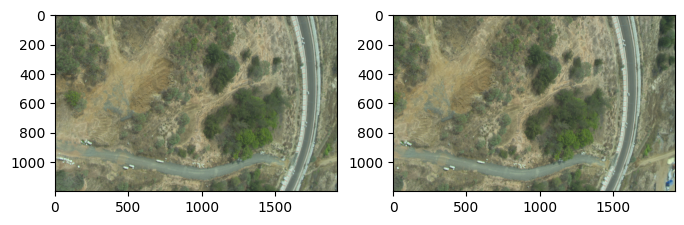

In [15]:
seed_num = 1
first_frame, second_frame = resized_frames[seed_num], resized_frames[seed_num + 1]
first_frame, second_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB), cv2.cvtColor(second_frame, cv2.COLOR_BGR2RGB)
print(first_frame.shape, second_frame.shape)

fig, axs = plt.subplots(1, 2, figsize = (8, 8))
axs[0].imshow(first_frame)
axs[1].imshow(second_frame)

plt.show()

In [16]:
sift = cv2.SIFT_create()
baseImage_kp, baseImage_des = sift.detectAndCompute(cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY), None)
secImage_kp, secImage_des = sift.detectAndCompute(cv2.cvtColor(second_frame, cv2.COLOR_RGB2GRAY), None)

print("(x, y): ", baseImage_kp[0].pt, ', radius: ', baseImage_kp[0].size)

(x, y):  (6.797672748565674, 774.3764038085938) , radius:  3.0484347343444824


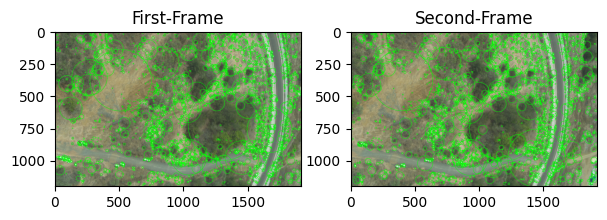

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(plot_key_points(first_frame, baseImage_kp))
axs[0].set_title('First-Frame')
axs[1].imshow(plot_key_points(second_frame, secImage_kp))
axs[1].set_title('Second-Frame')

plt.show()

In [18]:
BF_Matcher = cv2.BFMatcher()
InitialMatches = BF_Matcher.knnMatch(baseImage_des, secImage_des, k=2)

# Applying ratio test and filtering out the good matches.
GoodMatches = []
threshold = 0.75
for m, n in InitialMatches:
    if m.distance < threshold * n.distance: ## Within 75% CI
        GoodMatches.append([m])

print('No. of Good Matches: ', len(GoodMatches))

No. of Good Matches:  2422


In [19]:
rand_idx = np.random.permutation(len(GoodMatches))[:20]
some_GoodMatches = [GoodMatches[i] for i in rand_idx]

(1200, 3840, 3)


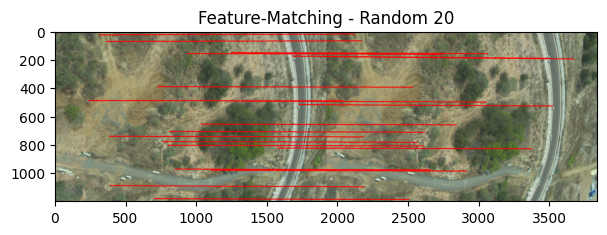

In [20]:
output_image = plot_feature_matches(first_frame, second_frame, baseImage_kp, secImage_kp, some_GoodMatches)
print(output_image.shape)

fig = plt.figure(figsize = (7, 7))

plt.imshow(output_image)
plt.title('Feature-Matching - Random 20')

plt.show()

Recover Camera Pose (R, T) + K (camera-matrix) to find camera projection matric (P) --> Find 3D-coordinates (using traingulation) --> Perform non-linear optimization (least-squares) (Ceres Solver) to optimize (3D coordinates and extrinsic parameters)   

In [21]:
def calculate_projection_matrix(K, R, t):
    P = np.zeros((3, 4))
    P[:3, :3] = R @ K
    P[:3, 3] = t.flatten()

    return P

def traingulate(x1, x2, P1, P2):

  A = np.zeros((4, 4))
  A[0] = x1[0] * P1[2] - P1[0]
  A[1] = x1[1] * P1[2] - P1[1]
  A[2] = x2[0] * P2[2] - P2[0]
  A[3] = x2[1] * P2[2] - P2[1]

  U, S, Vt = np.linalg.svd(A)
  V = Vt.T
  X = V[:, -1]  # Last column of V is the 3D point

  return X / X[3]  # Normalize to homogeneous coordinates

In [22]:
baseImage_pts, secImage_pts = [], []
print('Camera-Matrix: ', camera_matrix)

for match in GoodMatches:
    baseImage_pts.append(baseImage_kp[match[0].queryIdx].pt)
    secImage_pts.append(secImage_kp[match[0].trainIdx].pt)

first_pose = [np.eye(3), np.zeros((3, 1))]
E, mask = cv2.findEssentialMat(np.array(baseImage_pts), np.array(secImage_pts), camera_matrix, method = cv2.RANSAC)
_, R, t, mask = cv2.recoverPose(E, np.array(baseImage_pts), np.array(secImage_pts), camera_matrix)
second_pose = [R @ first_pose[0], R @ first_pose[-1] + t]

print(first_pose)
print()
print(second_pose)

P1, P2 = calculate_projection_matrix(camera_matrix, R, t), calculate_projection_matrix(camera_matrix, R, t)
print()
print('Camera-Projection-Matrix: ')
print(P1, P2)
print(P1.shape, P2.shape)

select_point_2d = 2
x1, x2 = baseImage_kp[select_point_2d].pt, secImage_kp[select_point_2d].pt
print('(x1, x2) : ', x1, x2)


Camera-Matrix:  [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[0.],
       [0.],
       [0.]])]

[array([[ 9.99826033e-01, -1.25880649e-02, -1.37638594e-02],
       [ 1.25755464e-02,  9.99920429e-01, -9.95694528e-04],
       [ 1.37752981e-02,  8.22433257e-04,  9.99904778e-01]]), array([[-0.99814897],
       [ 0.01501606],
       [-0.05893353]])]

Camera-Projection-Matrix: 
[[ 7.18730943e+02 -9.04900601e+00  6.04741898e+02 -9.98148965e-01]
 [ 9.04000700e+00  7.18798800e+02  1.92835748e+02  1.50160612e-02]
 [ 9.90245566e+00  5.91211082e-01  9.51649413e+00 -5.89335344e-02]] [[ 7.18730943e+02 -9.04900601e+00  6.04741898e+02 -9.98148965e-01]
 [ 9.04000700e+00  7.18798800e+02  1.92835748e+02  1.50160612e-02]
 [ 9.90245566e+00  5.91211082e-01  9.51649413e+00 -5.89335344e-02]]
(3, 4) (3, 4)
(x1, x2) :  (8.784207344055176, 581.3931274414062) (10.217535972595215, 634.5595703125)


In [23]:
print(traingulate(x1, x2, P1, P2).shape) 
point_3d = traingulate(x1, x2, P1, P2)[:-1] 

two_cam_centers = [-np.matmul(first_pose[0].T, first_pose[-1]), -np.matmul(second_pose[0].T, second_pose[-1])]
cam1_center, cam2_center = two_cam_centers

print(two_cam_centers)

(4,)
[array([[-0.],
       [-0.],
       [-0.]]), array([[ 0.99859831],
       [-0.02753116],
       [ 0.04520449]])]


### Plot 3-D Dynamics | from Triangulation

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

BA-2-View


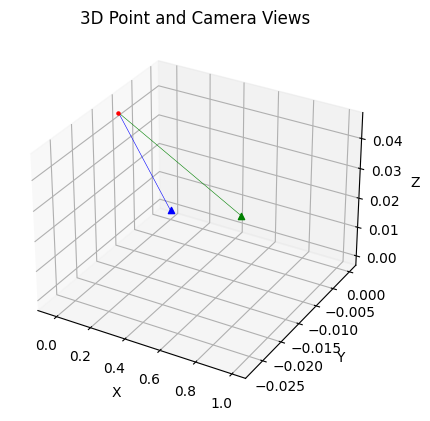

In [26]:
def two_single_3d_plot(two_cam_centers, point_3d): ## During BA, how a 3D points in WCS changes + how camera pose for consecutive frames changes   

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cam1_center, cam2_center = two_cam_centers 
    ax.scatter(point_3d[0], point_3d[1], point_3d[2], c='r', marker='.')
    ax.scatter(cam1_center[0], cam1_center[1], cam1_center[2], c='b', marker='^')
    ax.scatter(cam2_center[0], cam2_center[1], cam2_center[2], c='g', marker='^')

    x1, y1, z1 = ([cam1_center[0][0], point_3d[0]]), [cam1_center[1][0], point_3d[1]], [cam1_center[-1][0], point_3d[-1]]
    x2, y2, z2 = ([cam2_center[0][0], point_3d[0]]), [cam2_center[1][0], point_3d[1]], [cam2_center[-1][0], point_3d[-1]]

    ax.plot(x1, y1, z1, c='b', linewidth = 0.4)
    ax.plot(x2, y2, z2, c='g', linewidth = 0.4)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point and Camera Views')

two_single_3d_plot(two_cam_centers, point_3d)

print('BA-2-View')

plt.show()

#### Optimization

In [27]:
import time
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares
import urllib
import bz2

Sample-Run


    1. camera_params (n_cameras, 9) contains initial estimates of parameters for all cameras. First 3 components in each row form a rotation vector, next 3 components form a translation vector, then a focal distance and two distortion parameters.
    2. points_3d (n_points, 3) contains initial estimates of point coordinates in the world frame.
    3. camera_ind (n_observations,) contains indices of cameras (from 0 to n_cameras - 1) involved in each observation.
    4. point_ind (n_observations,) contatins indices of points (from 0 to n_points - 1) involved in each observation.
    5. points_2d (n_observations, 2) contains measured 2-D coordinates of points projected on images in each observations.


In [28]:

BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

temp_camera_params, temp_points_3d, temp_camera_indices, temp_point_indices, temp_points_2d = read_bal_data(FILE_NAME)
camera_feature = 9
temp_camera_params = temp_camera_params[:, :camera_feature]
print(temp_camera_params.shape, temp_points_3d.shape, temp_points_2d.shape)
print()
print(temp_camera_indices.shape, temp_point_indices.shape)
print(temp_camera_indices[:10], temp_point_indices[:10])
print(len(set(temp_camera_indices)), len(set(temp_point_indices)))
print(temp_points_2d[:10])

(49, 9) (7776, 3) (31843, 2)

(31843,) (31843,)
[ 0  1  3 26 29 36  0  1  4  8] [0 0 0 0 0 0 1 1 1 1]
49 7776
[[-332.65     262.09   ]
 [-199.76     166.7    ]
 [-253.06     202.27   ]
 [  58.13     271.89   ]
 [ 238.22     237.37   ]
 [ 317.55     221.15   ]
 [ 122.41      65.54999]
 [ 123.39      60.03003]
 [ 122.68      70.53998]
 [ 126.96      77.32001]]


In [29]:
print(temp_points_3d.shape, temp_points_3d.shape[0] * temp_points_3d.shape[1], temp_point_indices.shape)
print(temp_points_3d.shape)
print(temp_points_3d[temp_point_indices].shape)

print(temp_points_3d[temp_point_indices][:6], temp_points_3d[0])

(7776, 3) 23328 (31843,)
(7776, 3)
(31843, 3)
[[-0.61200016  0.57175905 -1.84708128]
 [-0.61200016  0.57175905 -1.84708128]
 [-0.61200016  0.57175905 -1.84708128]
 [-0.61200016  0.57175905 -1.84708128]
 [-0.61200016  0.57175905 -1.84708128]
 [-0.61200016  0.57175905 -1.84708128]] [-0.61200016  0.57175905 -1.84708128]


In [30]:
def rotate(points, rot_vecs):

    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

def project_2d_upd(points, camera_params):

    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    
    return points_proj

def project_2d(points, camera_params):
    
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:camera_feature]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]

    # fx, fy = camera_params[:, camera_feature], camera_params[:, camera_feature]
    # f = (fx + fy) / 2
    # points_proj *= f[:, np.newaxis]
    
    return points_proj

def func(params, n_cameras, n_points, camera_indices, point_indices, points_2d):

    camera_params = params[:n_cameras * camera_feature].reshape((n_cameras, camera_feature))
    points_3d = params[n_cameras * camera_feature:].reshape((n_points, 3))
    
    # points_proj = project_2d_upd(points_3d[point_indices], camera_params[camera_indices])
    points_proj = project_2d(points_3d[point_indices], camera_params[camera_indices])
    
    return (points_proj - points_2d).ravel()

In [32]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * camera_feature + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(camera_feature):
        A[2 * i, camera_indices * camera_feature + s] = 1
        A[2 * i + 1, camera_indices * camera_feature + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * camera_feature + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * camera_feature + point_indices * 3 + s] = 1

    return A

In [216]:
# images = resized_frames[:5]
# points_3d_flat, points_2d, camera_params_flat = incremental_sfm(images, camera_matrix, want_data = True)
# n_cameras = len(camera_params_flat)
# n_points = len(points_3d_flat)
# x0 = np.hstack((camera_params_flat.ravel(), points_3d_flat.ravel()))

temp_n_cameras = temp_camera_params.shape[0]
temp_n_points = temp_points_3d.shape[0]
temp_x0 = np.hstack((temp_camera_params.ravel(), temp_points_3d.ravel()))
print(temp_x0.shape)

f0 = func(temp_x0, temp_n_cameras, temp_n_points, temp_camera_indices, temp_point_indices, temp_points_2d)

A = bundle_adjustment_sparsity(temp_n_cameras, temp_n_points, temp_camera_indices, temp_point_indices)

t0 = time.time()
res = least_squares(func, temp_x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(temp_n_cameras, temp_n_points, temp_camera_indices, temp_point_indices, temp_points_2d))
t1 = time.time()

(23769,)
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.24e+02       1.54e+04    
       6              9         1.3436e+04      4.55e+01       3.18e+02       2.73e+04    
       7             10         1.3422e+04      1.36e+01       6.81e+01       2.18e+03    
       8             11         1.3418e+04      3.69e+00       1.27e+02       7.95e+03    
       9             12         1.3414e+04      4.20e+00       2.62e+01       6.1

-----

In [33]:
import cv2
import numpy as np
from scipy.optimize import least_squares
import bisect

In [34]:
def finding_index(target_3d_point, point_3d_corpus, inc_camera_idx_list):

    target_3d_point, point_3d_corpus = target_3d_point.T[:, :3], np.squeeze(point_3d_corpus)[:, :3]
    # print(target_3d_point.shape, point_3d_corpus.shape)
    distances = np.linalg.norm(point_3d_corpus - target_3d_point, axis=1)
    closest_point_idx = np.argmin(distances)
    closest_camera_idx = bisect.bisect_right(inc_camera_idx_list, closest_point_idx) - 1

    return closest_camera_idx, closest_point_idx

temp_3d_point = np.array([[-0.03287113],
  [-0.00326499],
  [ 0.04161941],
  [ 0.99858733]])

sample_3d_corpus = np.array([[[-0.03746069],
  [-0.00291197],
  [ 0.04606442],
  [ 0.99823158]],

 [[-0.02200075],
  [-0.00286068],
  [ 0.02786419],
  [ 0.99936548]],

 [[-0.03287113],
  [-0.00326499],
  [ 0.04161941],
  [ 0.99858733]]])

inc_camera_idx_list = [0, 2, 3]
print(temp_3d_point.shape, sample_3d_corpus.shape)
closest_camera_idx, closest_point_idx = finding_index(temp_3d_point, sample_3d_corpus, inc_camera_idx_list)
print(closest_camera_idx, closest_point_idx)

(4, 1) (3, 4, 1)
1 2


In [35]:
def incremental_sfm(images, intrinsic_matrix, want_data = False):
    """
    Performs incremental structure-from-motion and bundle adjustment for optical stitching.
    """

    print('Runnimg Bundle Adjustment ... ')

    # Initialize variables
    points_3d = []
    camera_poses = []
    points_2d = []
    matched_points_2d = []
    descriptors = []
    camera_idx_list = []
    point_idx_list = []
    inc_camera_idx_list = []

    # Detect and compute features for all images
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, desc = cv2.SIFT_create().detectAndCompute(gray, None)
        points_2d.append(np.array([kp[i].pt for i in range(len(kp))]))
        descriptors.append(desc)

    ### Need to match features here.
    init_matches = match_features(descriptors[0], descriptors[1])
    print(init_matches, type(init_matches))
    m1_idx, m2_idx = init_matches[:, 0], init_matches[:, 1]
    kp1, kp2 = np.array(points_2d[0][m1_idx]), np.array(points_2d[1][m2_idx])

    E, mask = cv2.findEssentialMat(kp1, kp2, intrinsic_matrix, cv2.RANSAC)
    _, R, t, mask_triangulated = cv2.recoverPose(E, kp1, kp2, intrinsic_matrix, mask)

    camera_poses.append((np.zeros(3), np.zeros(3)))
    camera_poses.append((cv2.Rodrigues(R)[0].ravel(), t.ravel()))

    print('AVC')
    print('Camera-Poses: ', camera_poses, len(camera_poses))

    ## constructed 4x1 Matrix (in Homogeneous Coordinate System) | 3x4 matrix (1-dim for scale) --> camera projection matrix
    p1_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[0][0])[0], camera_poses[0][1])
    p2_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[1][0])[0], camera_poses[1][1])

    print(p1_cam.shape, p2_cam.shape, kp1.shape, kp2.shape)

    points_3d_cur = np.array([cv2.triangulatePoints(p1_cam, p2_cam, key_0, key_1) for key_0, key_1 in zip(kp1, kp2)])
    m_points_2d = [(key_0, key_1) for key_0, key_1 in zip(kp1, kp2)]
    print()
    print('Point_3D_shape: ', points_3d_cur.shape)

    points_3d.append(points_3d_cur)
    matched_points_2d.append(m_points_2d)

    # Incrementally add new images and points
    for i in range(2, len(images)):

        matches = match_features(descriptors[i - 1], descriptors[i])
        m1_idx, m2_idx = matches[:, 0], matches[:, 1]
        kp1, kp2 = np.array(points_2d[i - 1][m1_idx]), np.array(points_2d[i][m2_idx])

        E, mask = cv2.findEssentialMat(kp1, kp2, intrinsic_matrix, cv2.RANSAC)
        _, R, t, mask_triangulated = cv2.recoverPose(E, kp1, kp2, intrinsic_matrix, mask)

        camera_poses.append((cv2.Rodrigues(R)[0].ravel(), t.ravel()))

        p1_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[i - 1][0])[0], camera_poses[i - 1][1])
        p2_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[i][0])[0], camera_poses[i][1])

        if i == 2:
          print('Projection-Camera-Matrix - ')
          print(p1_cam.shape, p2_cam.shape)

        points_3d_new = np.array([cv2.triangulatePoints(p1_cam, p2_cam, key_0, key_1) for key_0, key_1 in zip(kp1, kp2)])
        m_points_2d = [(key_0, key_1) for key_0, key_1 in zip(kp1, kp2)]

        matched_points_2d.append(m_points_2d)
        points_3d.append(points_3d_new)


    # Perform bundle adjustment
    points_3d_flat = np.array([p_ele for p in points_3d for p_ele in p]) ## Flatten all 3-D points in World-Coordinat-System, extracted from 2 view-stereo
    # print('Points-3D: ', len(points_3d))
    print('Flat-3D: ', points_3d_flat.shape)
    # print('(x, y, z): ', points_3d_flat[0])
    points_2d_flat = np.array([p_ele for p in points_2d for p_ele in p])
    # print('Points-2D: ', len(points_2d))
    print('Flat-2D: ', points_2d_flat.shape)
    descriptor_flat = np.array([d_ele for d in descriptors for d_ele in d])
    # print('Descriptors: ', descriptor_flat.shape)
    print('Matched-Points-2d: ', len(matched_points_2d))
    matched_points_2d_flat = np.array([m_ele for m in matched_points_2d for m_ele in m])
    print('Matched_points_2d_flat: ', matched_points_2d_flat.shape, matched_points_2d_flat[0].shape, matched_points_2d_flat[0])
    temp = [p.shape[0] for p in points_2d]
    k=0
    for ele in temp:
      k+=ele
      inc_camera_idx_list.append(k)

    print()
    inc_camera_idx_list = [0] + inc_camera_idx_list
    inc_camera_idx_list[-1] = inc_camera_idx_list[-1] - 1
    ('--- inc_camera_idx_list --- : ')
    print(len(inc_camera_idx_list), inc_camera_idx_list)
    print()

    ## Need camera_params to be (n_camera, 6)
    camera_params_flat = np.array([[r_ele, t_ele] for r, t in camera_poses for r_ele, t_ele in zip(r, t)]).reshape(-1, 6)
    # print('Camera-Poses: ', len(camera_poses), camera_poses.shape, camera_poses)
    print('Camera-Params-Flat: ', camera_params_flat.shape)

    ## Need to create indidces (taking camera frames as basis) for 3d points and thier corresponding camera parameters.
    ## Need to index corresponding camera_params for given 3d point

    # sys.exit(0)

    idx_i, cam_idx, point_idx = 1, 0, 0

    while idx_i != len(matched_points_2d_flat) + 1:

      ##  Matchced Key-Points traingulate 3D-points
      (x1, y1), (x2, y2) = matched_points_2d_flat[idx_i - 1][0], matched_points_2d_flat[idx_i - 1][-1]
      # print('Matched-Feature-Points: ', (x1, y1), (x2, y2))
      p1_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[cam_idx][0])[0], camera_poses[cam_idx][1])
      p2_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[cam_idx + 1][0])[0], camera_poses[cam_idx + 1][1])

      target_3d_points = cv2.triangulatePoints(p1_cam, p2_cam, (x1, y1), (x2, y2))
      closest_camera_idx, closest_point_idx = finding_index(target_3d_points, points_3d_flat, inc_camera_idx_list)

      camera_idx_list.append(closest_camera_idx)
      point_idx_list.append(closest_point_idx)

    #   print('IDX-I: ', idx_i)
      if idx_i in inc_camera_idx_list:
        cam_idx += 1
        # print(cam_idx)
      idx_i += 1

    camera_idx_list = np.array(camera_idx_list)
    camera_idx_list = np.concatenate([camera_idx_list, camera_idx_list], axis = 0)
    point_idx_list = np.array(point_idx_list)
    point_idx_list = np.concatenate([point_idx_list, point_idx_list], axis = 0)

    print('Camera-Idx-List: ', camera_idx_list.shape)
    print('Point-Idx-List: ', point_idx_list.shape)

    if want_data:
        return np.array(points_3d_flat), np.array(matched_points_2d_flat), np.array(camera_params_flat), camera_idx_list, point_idx_list

    # optimized_params = least_squares(reproject_error, x0, args=(points_2d, camera_matrix))
    # print('Optimization-Done!')
    # n_points = len(points_3d_flat) // points_3d_cur
    # optimized_points_3d = optimized_params.x[:n_points * 3].reshape((-1, 3))
    # optimized_camera_params = optimized_params.x[n_points * 3:].reshape((-1, 6))

    # return optimized_points_3d, [(r, t) for r, t in optimized_camera_params.reshape((-1, 6))]

def match_features(desc1, desc2):

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    print('Good-Matches: ', len(good_matches))
    return np.array([[m.queryIdx, m.trainIdx] for m in good_matches])

def reproject_error(params, points_2d, camera_matrix):

    n_points = len(params) // 6
    print(len(params), n_points, n_points*3, len(params) - n_points*3)
    points_3d = params[:n_points * 3].reshape((-1, 3))
    print(points_3d.shape)
    camera_params = params[(n_points * 3) + 1:].reshape((-1, 6))
    print(camera_params.shape)

    errors = []
    for i, rt in enumerate(camera_params):
        r, t = rt[:3], rt[3:]
        R, _ = cv2.Rodrigues(r)
        proj_matrix = np.hstack((R, t.reshape(3, 1)))
        points_2d_proj, _ = cv2.projectPoints(points_3d, r, t, camera_matrix, None)
        errors.extend((points_2d_proj.squeeze() - points_2d[i]).ravel())

    return np.array(errors)

In [36]:
images = resized_frames
ft = time.time()

## Problem of Non-Uniquensess
points_3d, points_2d, camera_params, camera_indices, point_indices = incremental_sfm(images, camera_matrix, want_data=True)
points_3d = np.squeeze(points_3d)[:, :3]

''' Raveling all the matched-feature points '''
temp_1, temp2 = points_2d[:, 0], points_2d[:, 1]
points_2d = np.concatenate([temp_1, temp2], axis = 0).copy()
print(points_2d.shape)
print()
print(points_3d.shape, points_2d.shape, camera_params.shape, camera_indices.shape, point_indices.shape)

lt = time.time()
print('Execution Time (UNIX): ', (lt - ft))

Runnimg Bundle Adjustment ... 
Good-Matches:  2440
[[   4    1]
 [   8    2]
 [  10    4]
 ...
 [3326 3185]
 [3329 3191]
 [3330 3192]] <class 'numpy.ndarray'>
AVC
Camera-Poses:  [(array([0., 0., 0.]), array([0., 0., 0.])), (array([0.00687854, 0.00013839, 0.00464445]), array([-0.06055078, -0.99488168, -0.08089532]))] 2
(3, 4) (3, 4) (2440, 2) (2440, 2)

Point_3D_shape:  (2440, 4, 1)
Good-Matches:  2422
Projection-Camera-Matrix - 
(3, 4) (3, 4)
Good-Matches:  2610
Good-Matches:  2597
Good-Matches:  2402
Good-Matches:  2286
Good-Matches:  2360
Good-Matches:  2360
Good-Matches:  2372
Good-Matches:  2538
Good-Matches:  2387
Good-Matches:  2549
Good-Matches:  2781
Good-Matches:  2733
Good-Matches:  2694
Good-Matches:  2751
Good-Matches:  2760
Good-Matches:  2894
Good-Matches:  2878
Good-Matches:  2782
Good-Matches:  2734
Good-Matches:  2581
Good-Matches:  2677
Good-Matches:  2920
Flat-3D:  (62508, 4, 1)
Flat-2D:  (91244, 2)
Matched-Points-2d:  24
Matched_points_2d_flat:  (62508, 2, 2) (2, 2)

In [37]:
zipped_indices = zip(camera_indices, point_indices)

print('-- point_indices --')
print(point_indices[:100])
print(set(point_indices))
print()
print('-- camera_indices --')
print(camera_indices[:100])
print(set(camera_indices))

sorted_zipped_indices = sorted(zipped_indices, key=lambda k: k[1], reverse=False)

camera_indices, point_indices = zip(*sorted_zipped_indices)
camera_indices, point_indices = np.array(list(camera_indices)), np.array(list(point_indices))

print()
print(camera_indices.shape, point_indices.shape)
print('-- Sorted -- ')
## Something Fishy!
print()
print(camera_indices[:30])
print() 
print(point_indices[:30])

-- point_indices --
[ 0  1  2  3  4  5  6  7  8  8 10 11 12 13 14 15 16 16 18 19 20 20 22 23
 24 25 25 27 27 29 30 31 32 33 34 34 36 37 38 38 40 41 42 43 44 45 45 47
 47 49 50 51 52 53 54 55 56 57 58 59 60 61 61 63 64 65 65 67 68 68 70 70
 72 73 74 75 76 77 78 79 80 81 82 83 83 85 86 87 88 88 90 91 92 93 94 95
 95 97 98 98]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 67, 68, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 97, 98, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 120, 123, 124, 126, 128, 129, 130, 132, 133, 135, 137, 138, 139, 142, 143, 145, 146, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 189, 

In [38]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]
print(point_indices.shape, camera_indices.shape)
camera_feature = 6

print('Number-Of-Cameras: ', n_cameras)
print('Number-Of-Points: ', n_points)

x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
print(x0.shape)

f0 = func(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

t0 = time.time()
res = least_squares(func, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

(125016,) (125016,)
Number-Of-Cameras:  25
Number-Of-Points:  62508
(187674,)
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.5177e+11                                    6.43e+16    
       1              2         2.0657e+11      1.45e+11       2.26e+06       7.88e+15    
       2              4         1.8178e+11      2.48e+10       4.46e+08       2.68e+15    
       3              8         1.4958e+11      3.22e+10       7.76e+03       2.35e+15    
       4              9         1.3533e+11      1.42e+10       1.58e+04       1.22e+15    
       5             10         1.1813e+11      1.72e+10       2.02e+04       4.28e+14    
       6             11         1.1161e+11      6.53e+09       4.45e+04       1.42e+14    
       7             13         1.0907e+11      2.54e+09       7.66e+03       1.13e+14    
       8             14         1.0871e+11      3.65e+08       1.76e+04       5.99e+13    
       9    

### Residuals

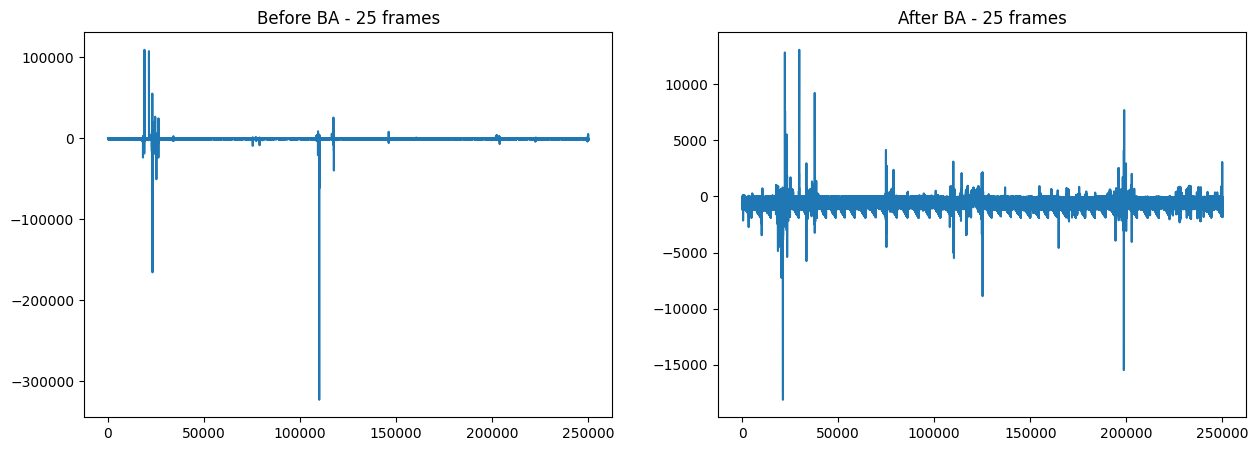

In [41]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(f0)
axs[0].set_title(f'Before BA - {num_frames} frames')

axs[1].plot(res.fun)
axs[1].set_title(f'After BA - {num_frames} frames')

plt.show()

Using the optimized 3d_points + Camera extrinsics to improve stitching + ON Canvas creation + Alpha Blending

In [ ]:
def stitch_frames(images, optimized_points_3d, optimized_camera_params, intrinsic_matrix):
    """
    Stitches optical frames using the optimized 3D points and extrinsic parameters.

    """

In [85]:
r = np.random.rand(3, 1)
print(r.shape)
temp = cv2.Rodrigues(r)
temp[0].shape

# camera_poses

(3, 1)


(3, 3)

In [58]:
from PIL import Image

img = Image.open(r'/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114647_20190804114904_tile_6254.tif')

plt.imshow(img)
plt.show()

UnidentifiedImageError: cannot identify image file '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114647_20190804114904_tile_6254.tif'